In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import HierarchicalBayesianModel
from constants import (
    TOML_PATH,
    DATA_PATH,
    BUILD_DIR,
    INFERENCE_FILE
)


In [2]:
src = "/home/vishu/repos/rat-mapping-paper/reports/log-hierarchical/L_CIRC/hierarchical_bayesian_4000W_4000S_4C_4T_20D_0.95A/inference.pkl"

with open(src, "rb") as f:
    df, encoder_dict, model, posterior_samples, = pickle.load(f)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
a = posterior_samples[site.a]
a.shape


(4000, 8, 21, 6)

In [5]:
positions_ind = sorted(df[model.features[1]].unique())
positions = encoder_dict[model.features[1]].inverse_transform(positions_ind)
positions


array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW', 'C6LE-C6LC', 'C6LE-C6LW', 'C6LN-C6LC',
       'C6LNE-C6LC', 'C6LNE-C6LSW', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LS-C6LN', 'C6LSE-C6LC', 'C6LSE-C6LNW', 'C6LSW-C6LC',
       'C6LW-C6LC'], dtype=object)

In [6]:
diff = a[:, :, :, None, :] - a[:, :, None, :, :]
diff = np.nanmean(diff, axis=0)
diff.shape

for i in range(diff.shape[1]):
    diff[:, i, i, :] = np.nan


In [7]:
test = stats.wilcoxon(diff, axis=(0,), alternative="less")

p = test.pvalue
p.shape


(21, 21, 6)

Saved to /home/vishu/repos/rat-mapping-paper/reports/log-hierarchical/L_CIRC/pvalues.png


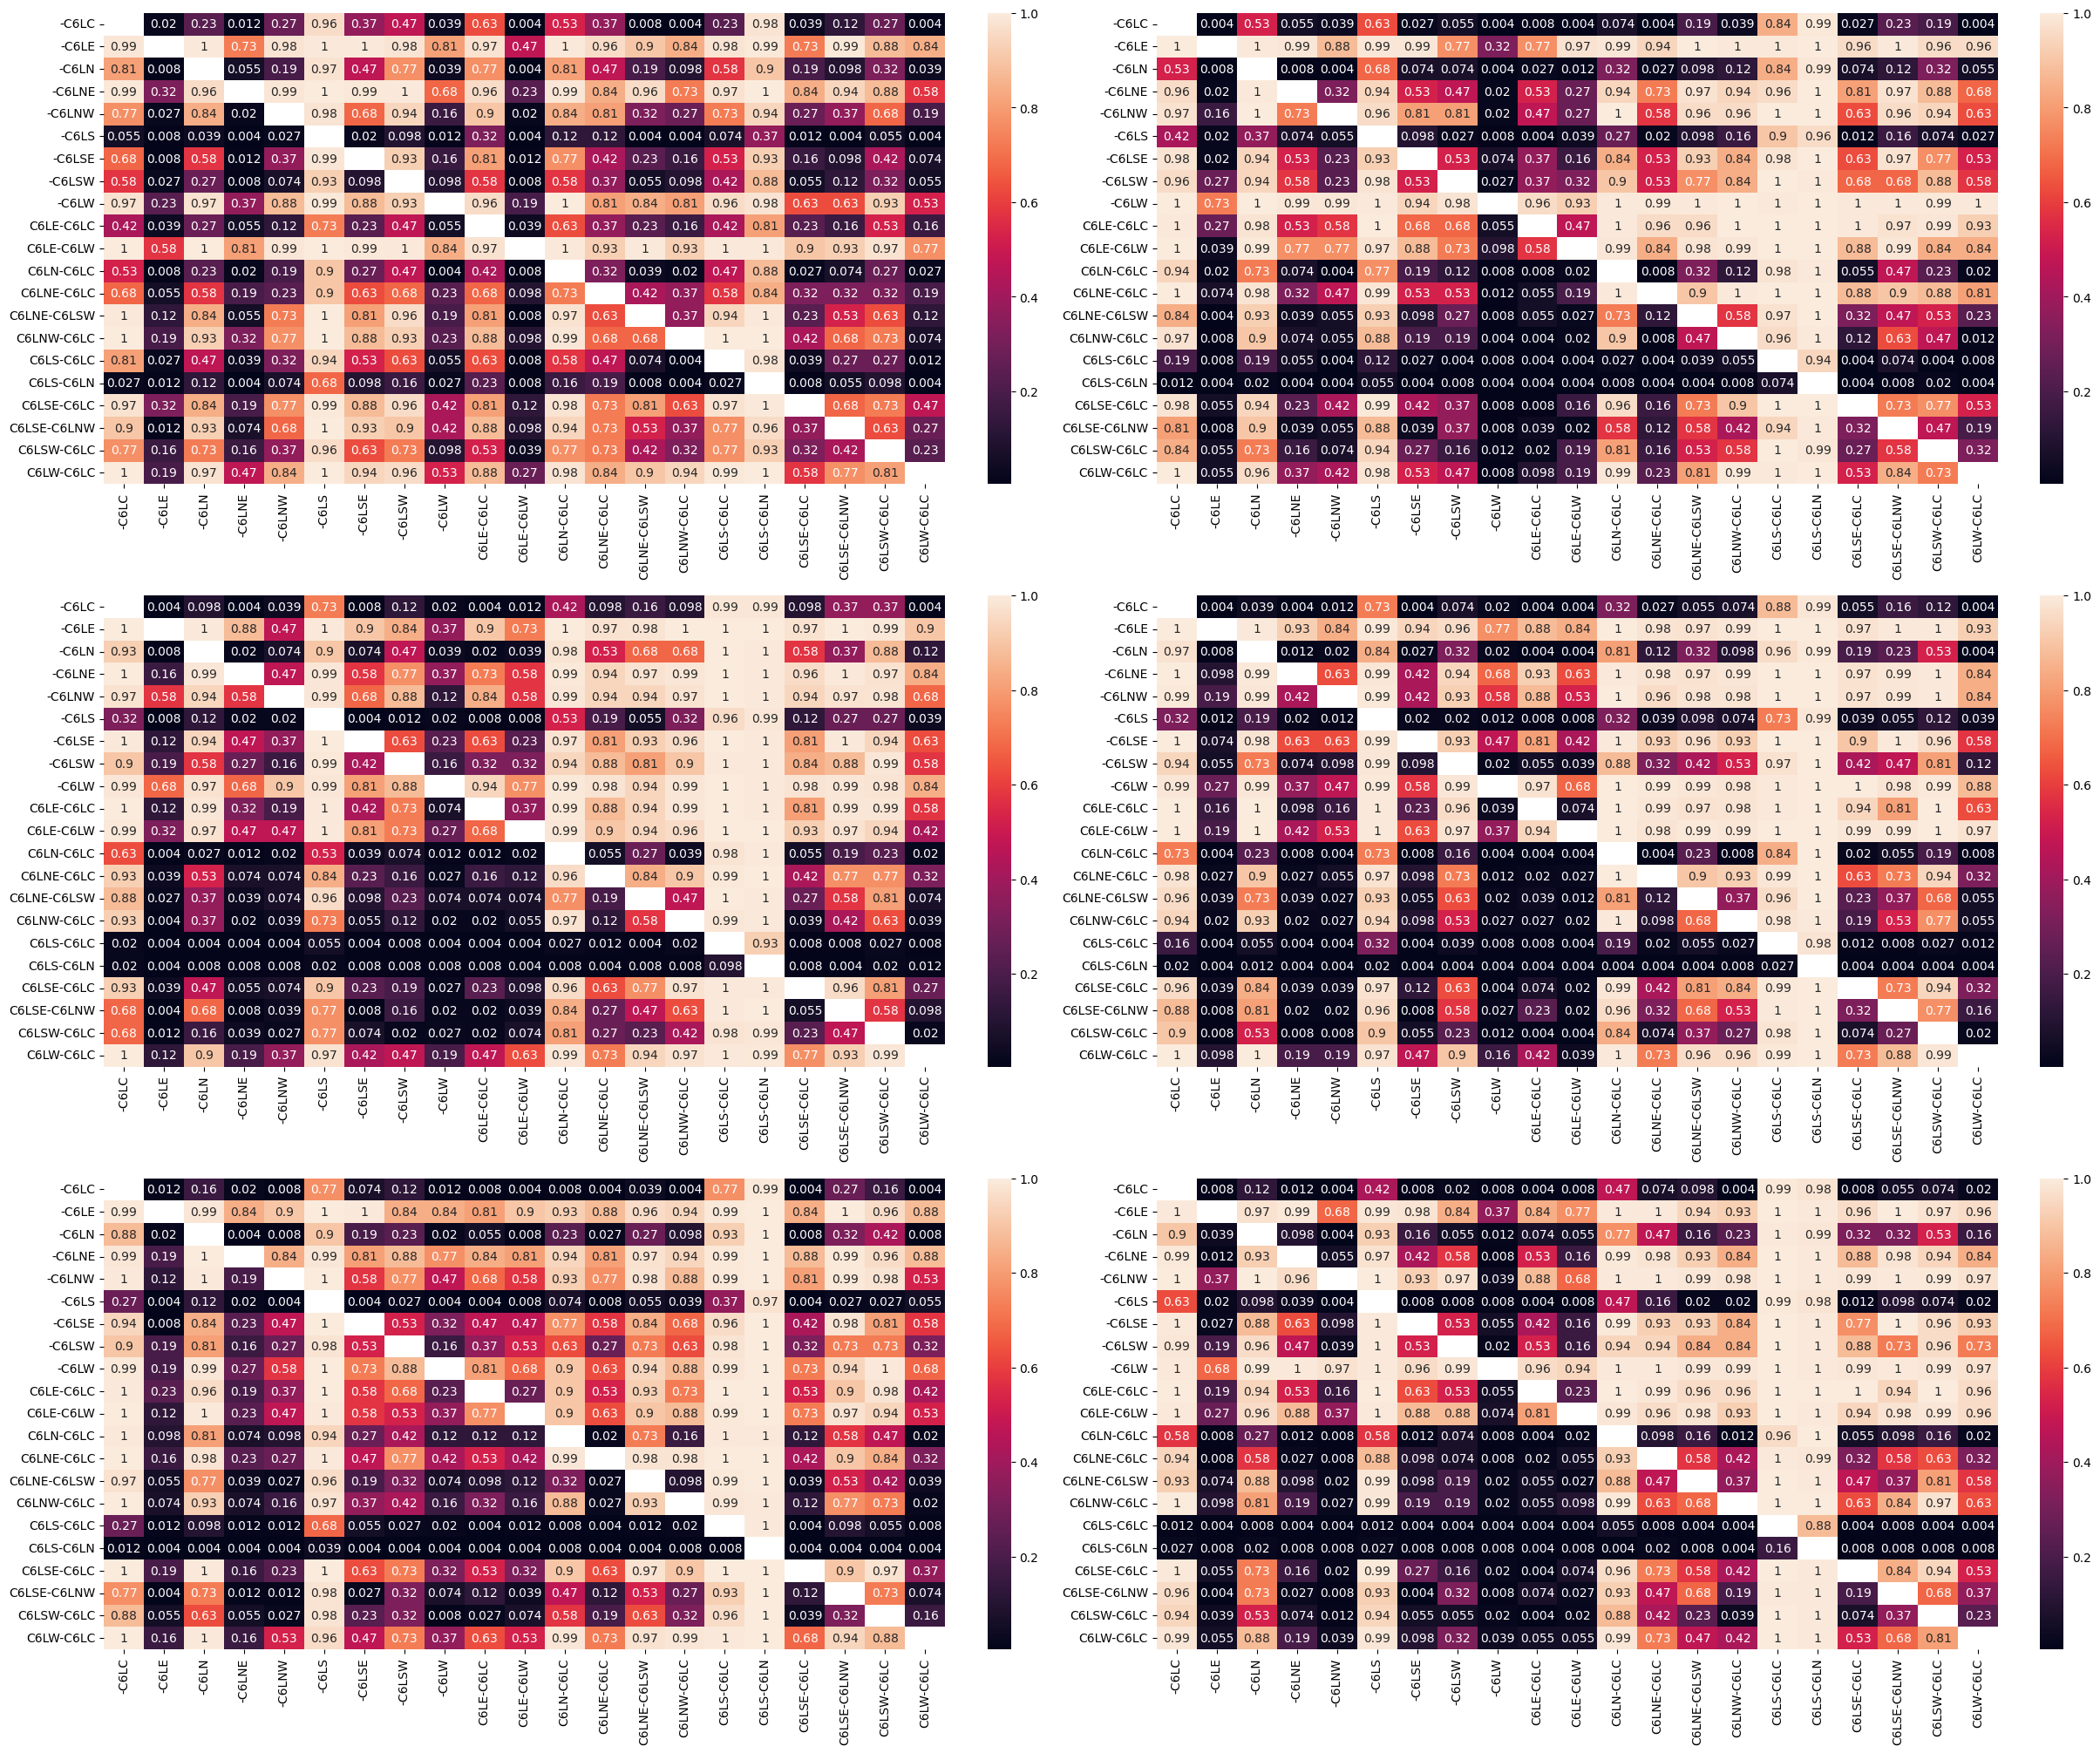

In [8]:
nr, nc = 3, 2
fig, axes = plt.subplots(
    nrows=nr, ncols=nc, squeeze=False, constrained_layout=True, figsize=(24, 20)
)

for i in range(p.shape[-1]):
    ax = axes[i // nc, i % nc]
    arr = p[..., i]
    sns.heatmap(np.round(arr, 3), ax=ax, xticklabels=positions, yticklabels=positions, annot=True)

dest = os.path.join(BUILD_DIR, "pvalues.png")
fig.savefig(dest)
print(f"Saved to {dest}")


/tmp/ipykernel_3931221/3949418811.py:6: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(diff, axis=(0, -1))


<Axes: >

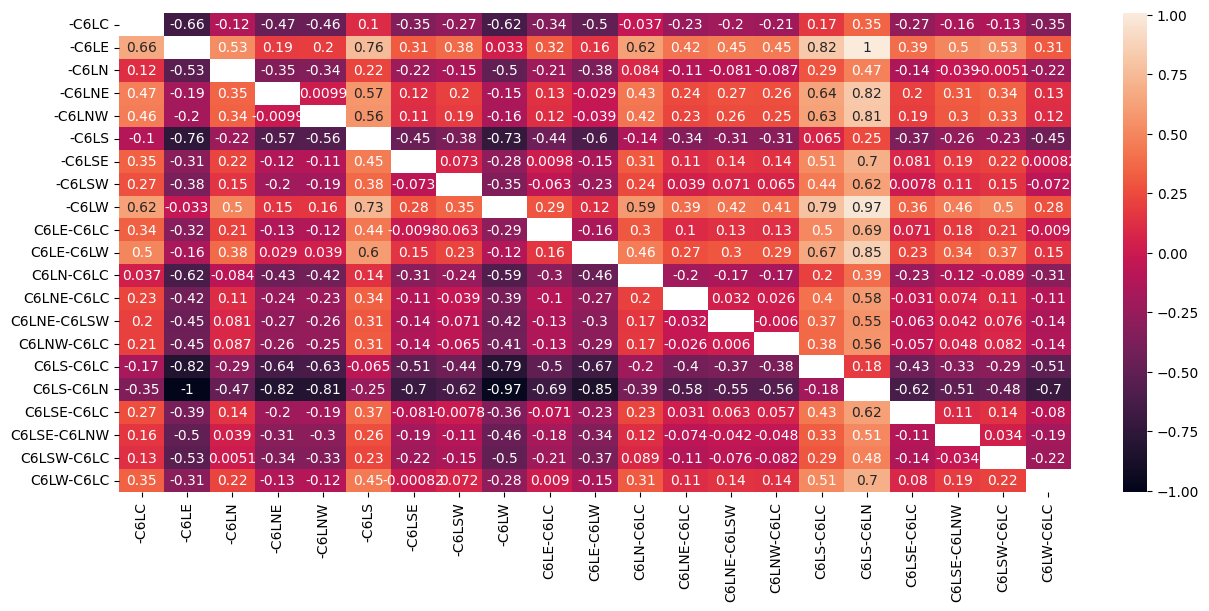

In [10]:
nr, nc = 1, 1
fig, axes = plt.subplots(
    nrows=nr, ncols=nc, squeeze=False, constrained_layout=True, figsize=(12, 6)
)

arr = np.nanmean(diff, axis=(0, -1))
ax = axes[0, 0]
sns.heatmap(arr, ax=ax, xticklabels=positions, yticklabels=positions, annot=True)


/tmp/ipykernel_3931221/3189968842.py:8: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(diff, axis=0)[..., i]
/tmp/ipykernel_3931221/3189968842.py:8: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(diff, axis=0)[..., i]
/tmp/ipykernel_3931221/3189968842.py:8: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(diff, axis=0)[..., i]
/tmp/ipykernel_3931221/3189968842.py:8: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(diff, axis=0)[..., i]
/tmp/ipykernel_3931221/3189968842.py:8: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(diff, axis=0)[..., i]
/tmp/ipykernel_3931221/3189968842.py:8: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(diff, axis=0)[..., i]


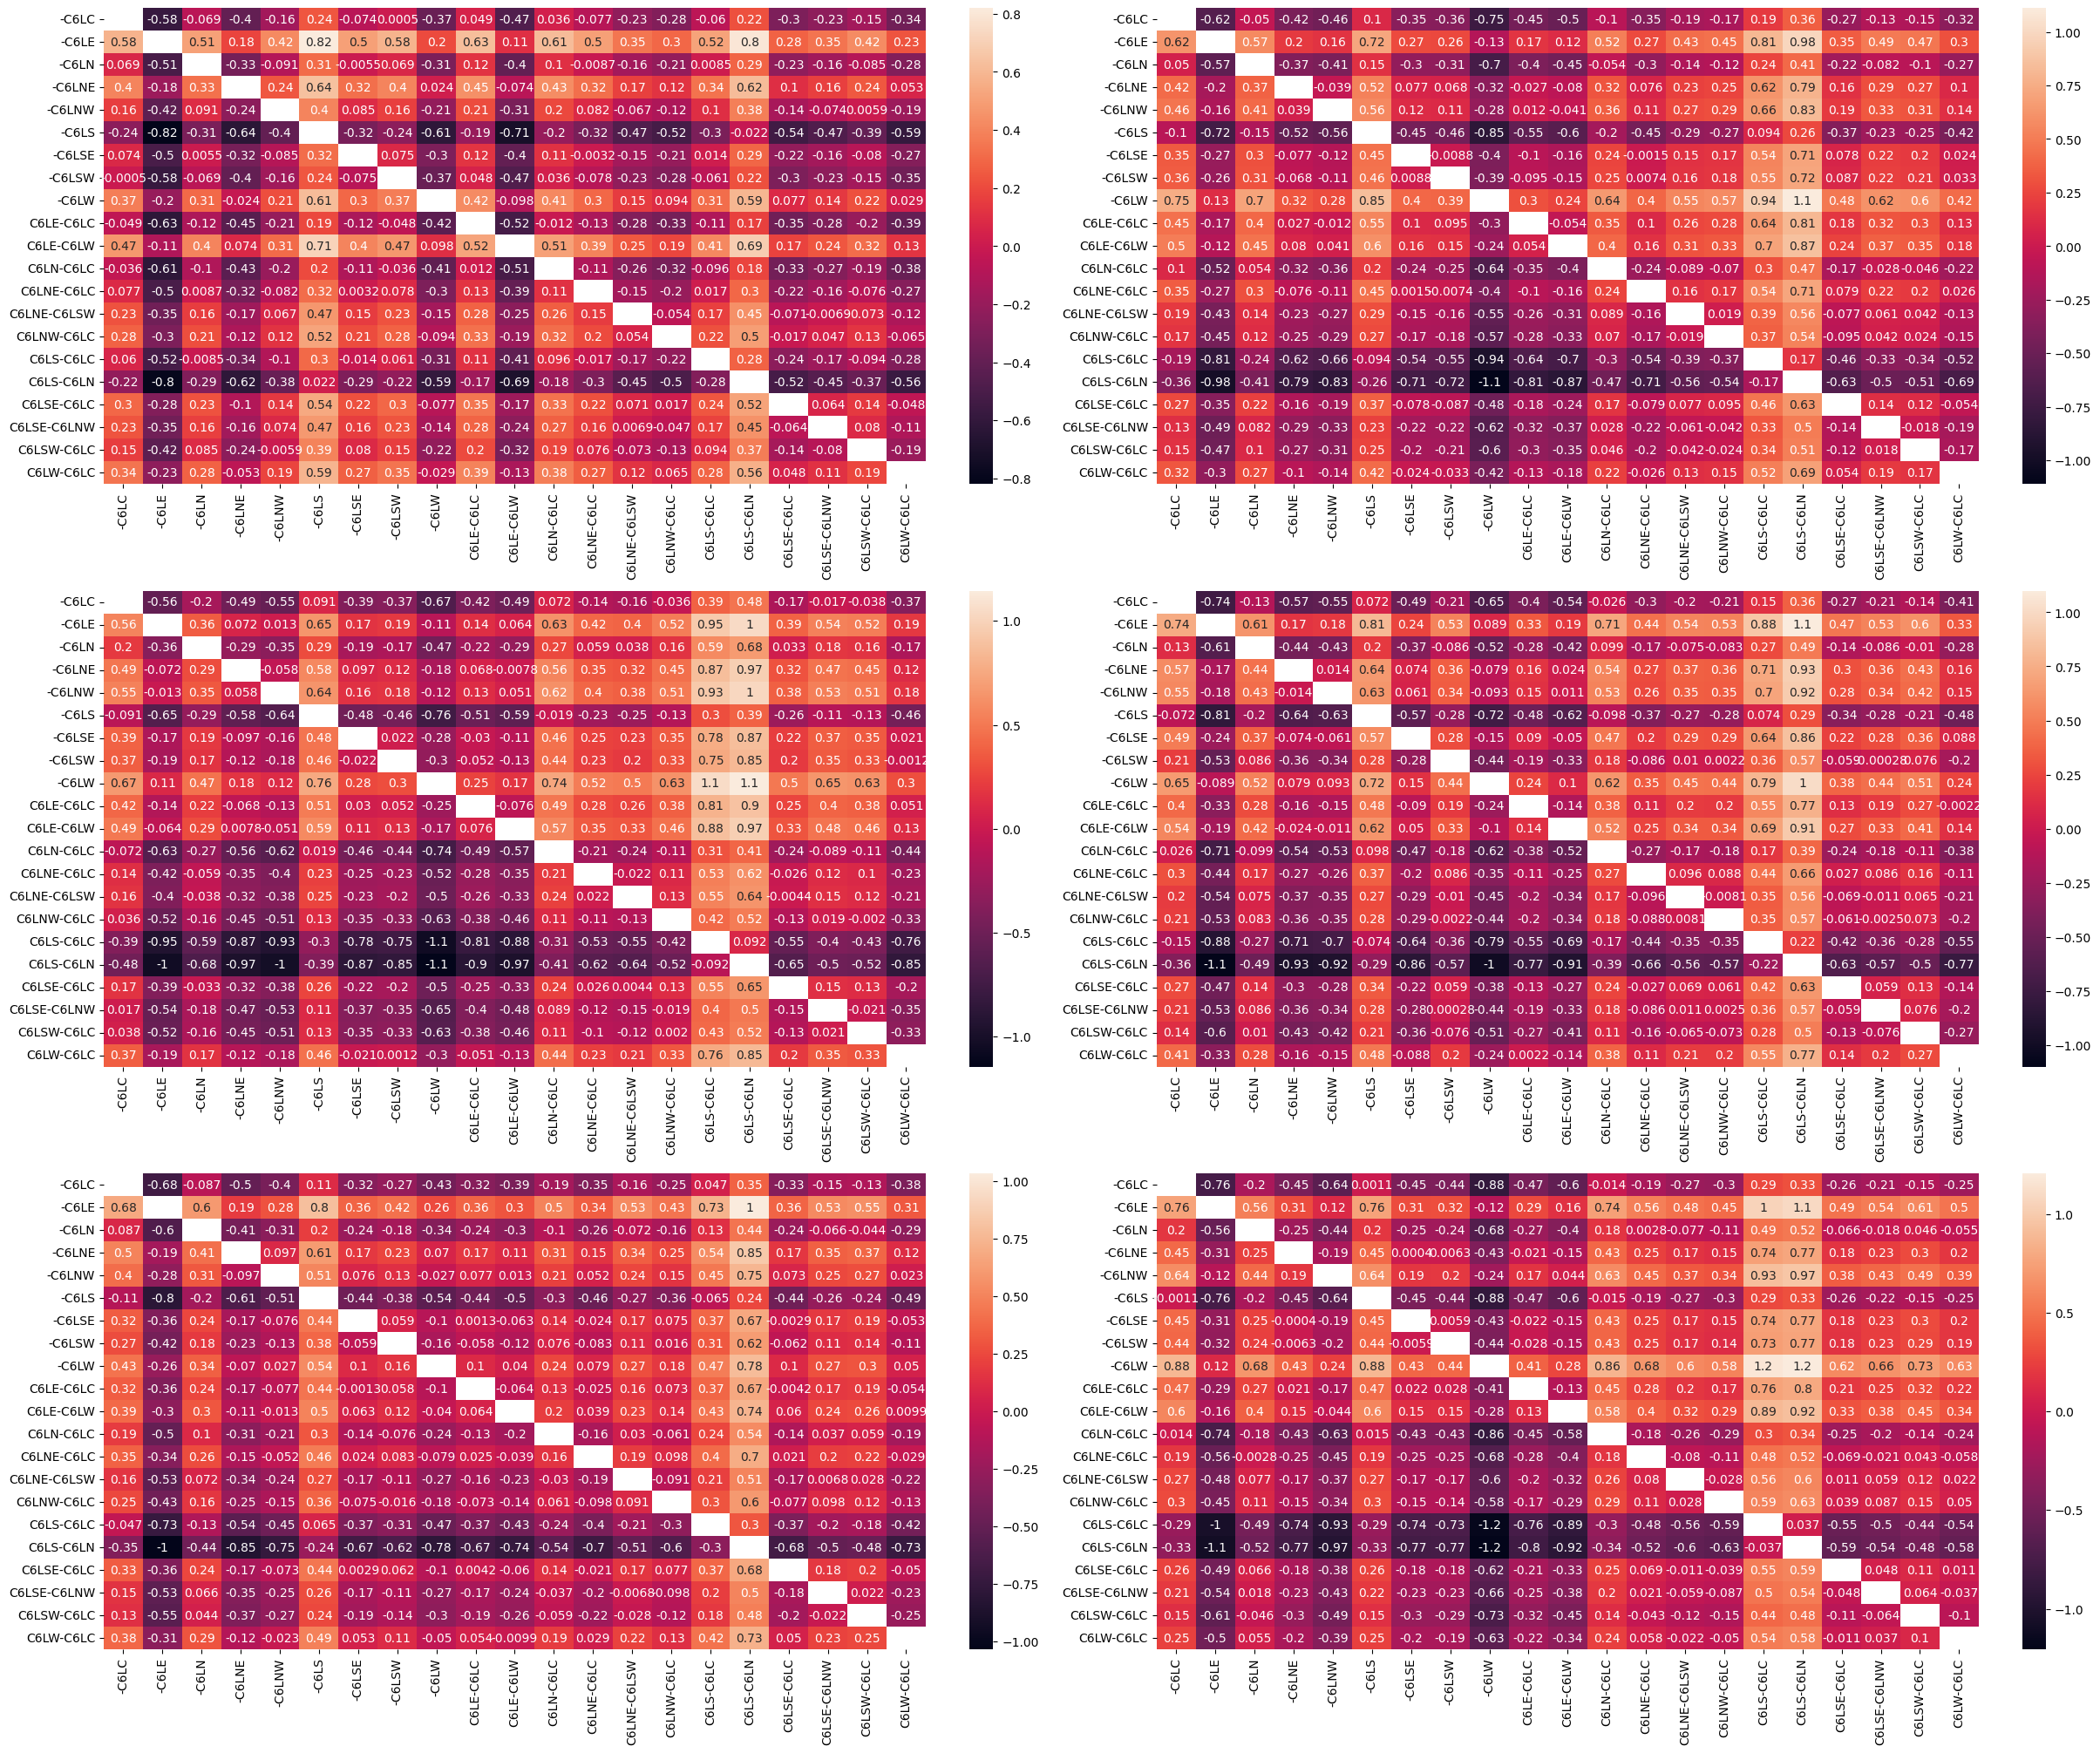

In [11]:
nr, nc = 3, 2
fig, axes = plt.subplots(
    nrows=nr, ncols=nc, squeeze=False, constrained_layout=True, figsize=(24, 20)
)

for i in range(diff.shape[-1]):
    ax = axes[i // nc, i % nc]
    arr = np.nanmean(diff, axis=0)[..., i]
    sns.heatmap(arr, ax=ax, xticklabels=positions, yticklabels=positions, annot=True)


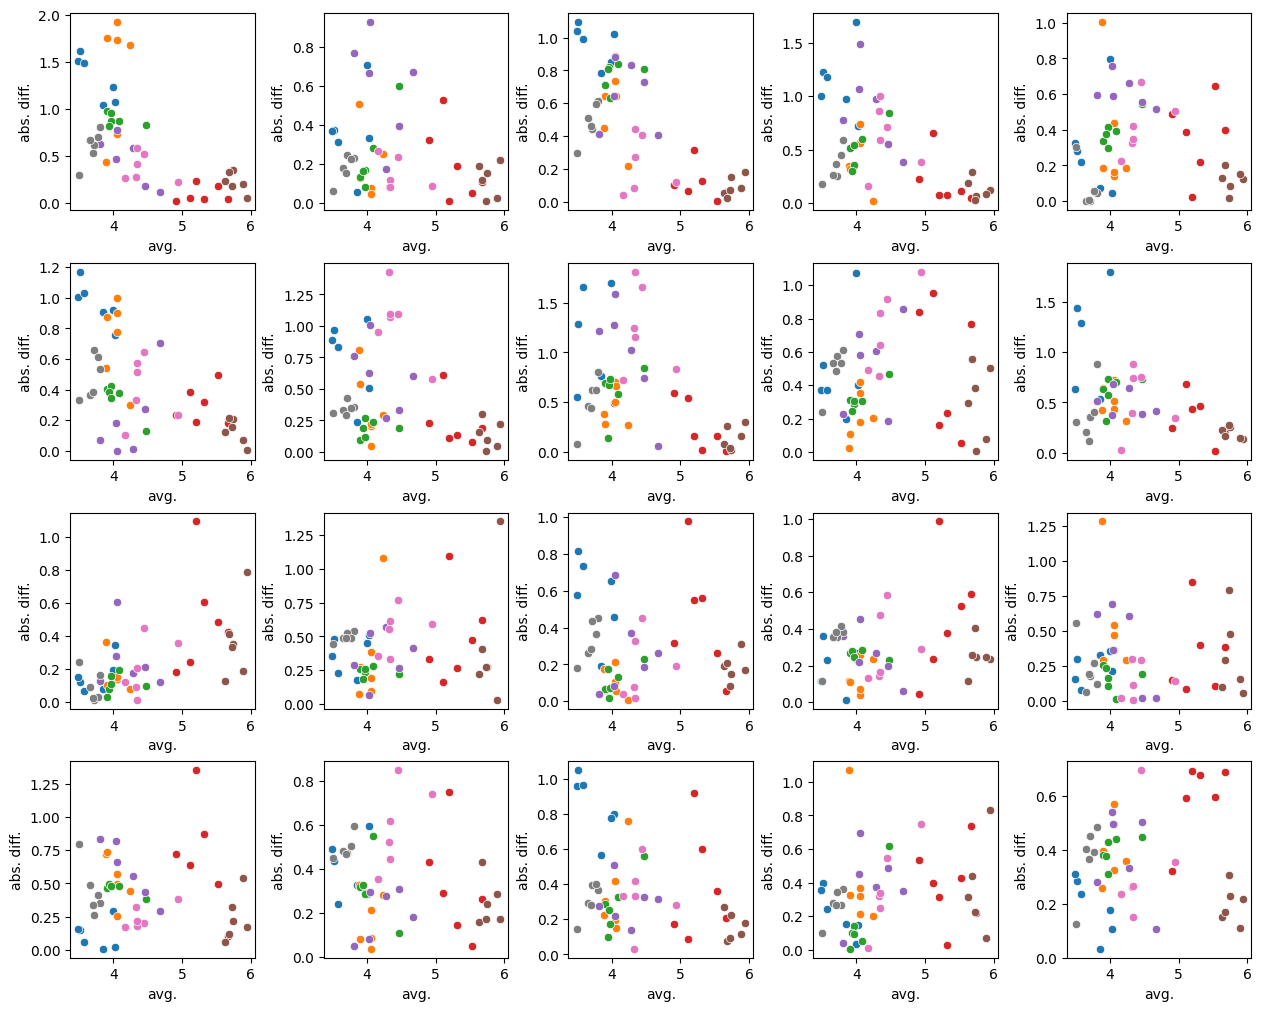

In [9]:
param = a.mean(axis=0)
x = param.mean(axis=-2)

nr, nc = 4, 5
fig, axes = plt.subplots(
    nrows=nr, ncols=nc, constrained_layout=True, squeeze=False, figsize=(2.5 * nc, 2.5 * nr)
)

left = 0
for j in range(1, param.shape[-2]):
    ax = axes[(j - 1) // nc, (j - 1) % nc]
    y = np.abs(param[:, left, :] - param[:, j, :])
    for rat_ind in range(y.shape[0]):
        sns.scatterplot(x=x[rat_ind, :], y=y[rat_ind, :], ax=ax)
    ax.set_xlabel("avg.")
    ax.set_ylabel("abs. diff.")
